In [ ]:
# pip install pmdarima
# pip install sktime

In [15]:
from sktime.datasets import load_uschange
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.datasets import load_macroeconomic, load_airline
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.stattools import kpss

import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)

In [61]:
data = pd.read_csv('Custom_location (1).csv')

In [62]:
data = data.tail(365*3)

In [25]:
data.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,precipitations
400377,1725354000,2024-09-03 09:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,25.93,NaN,10.93,25.60,...,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d,NaN
400378,1725357600,2024-09-03 10:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.73,NaN,9.58,26.41,...,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d,NaN
400379,1725361200,2024-09-03 11:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.67,NaN,9.08,26.33,...,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d,NaN
400380,1725364800,2024-09-03 12:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.64,NaN,9.06,26.64,...,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d,NaN
400381,1725368400,2024-09-03 13:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.68,NaN,9.09,26.34,...,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d,NaN


In [23]:
data.columns

Index(['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'temp',
       'visibility', 'dew_point', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed',
       'wind_deg', 'wind_gust', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

In [63]:
data['precipitations'] = data['rain_1h'] + data['snow_1h']

<Axes: >

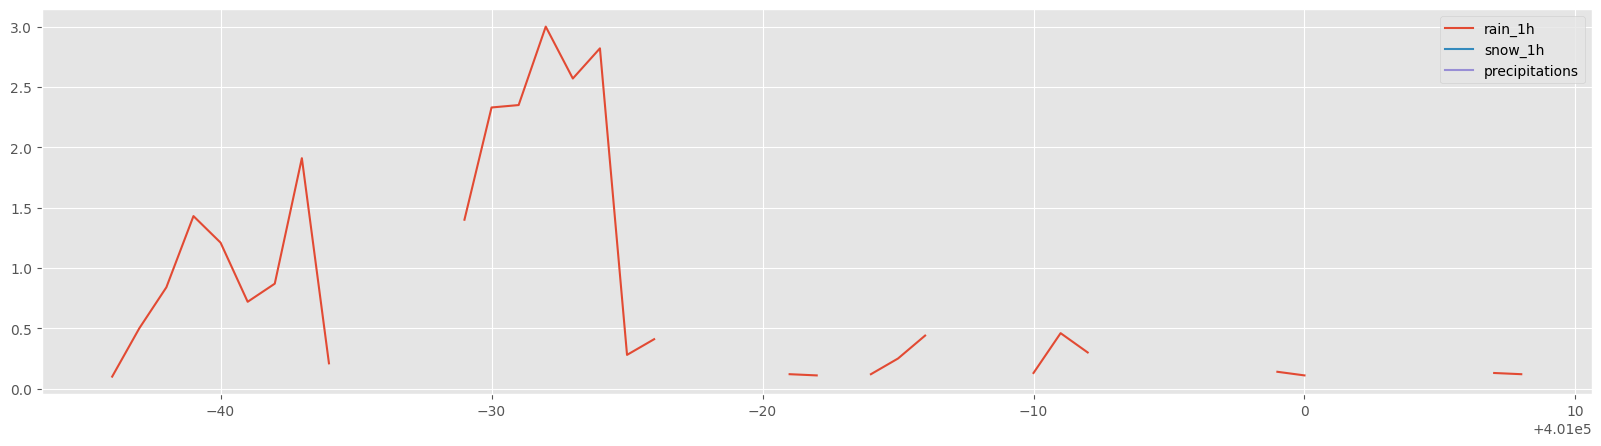

In [32]:
data[['rain_1h', 'snow_1h', 'precipitations']].plot()

То есть на количество осадков в общем-то смотреть бессмысленно. Мы это видели и на этапе EDA, но сейчас только убедились. Попробуем взять облачность

<Axes: >

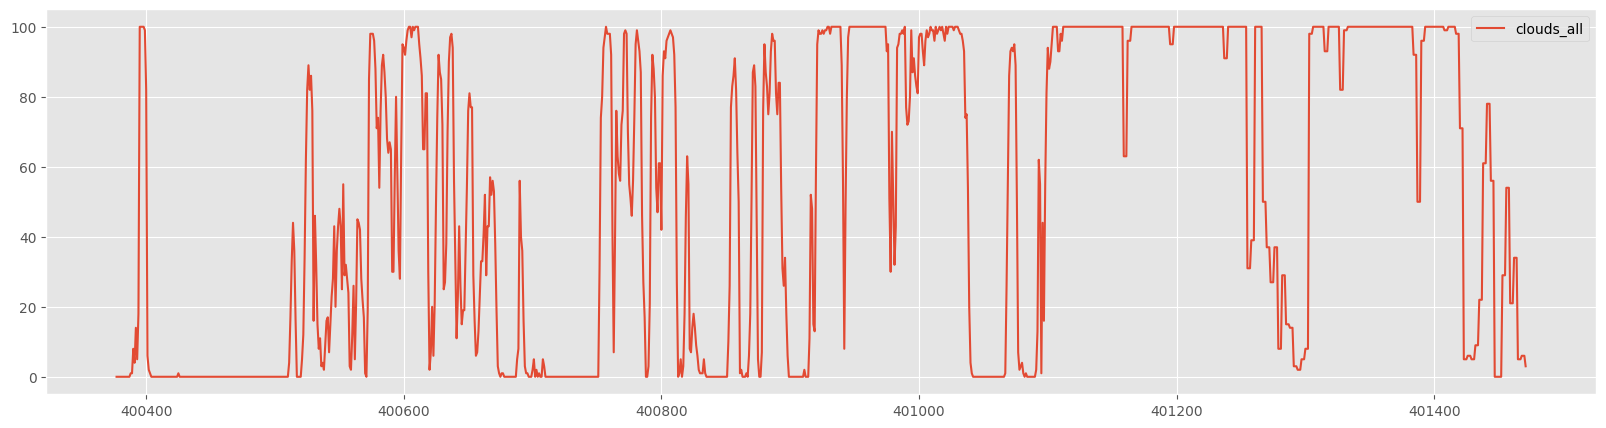

In [36]:
data[['clouds_all']].plot()

В общем-то выглядит тоже не как то, что можно прогнозировать каким-либо разумным способом. Сравним точку росы, ощущаемую температуру и актуальную температуру - может временные ряды различны и можно вытащить какие-то дополнительные признаки?

<Axes: >

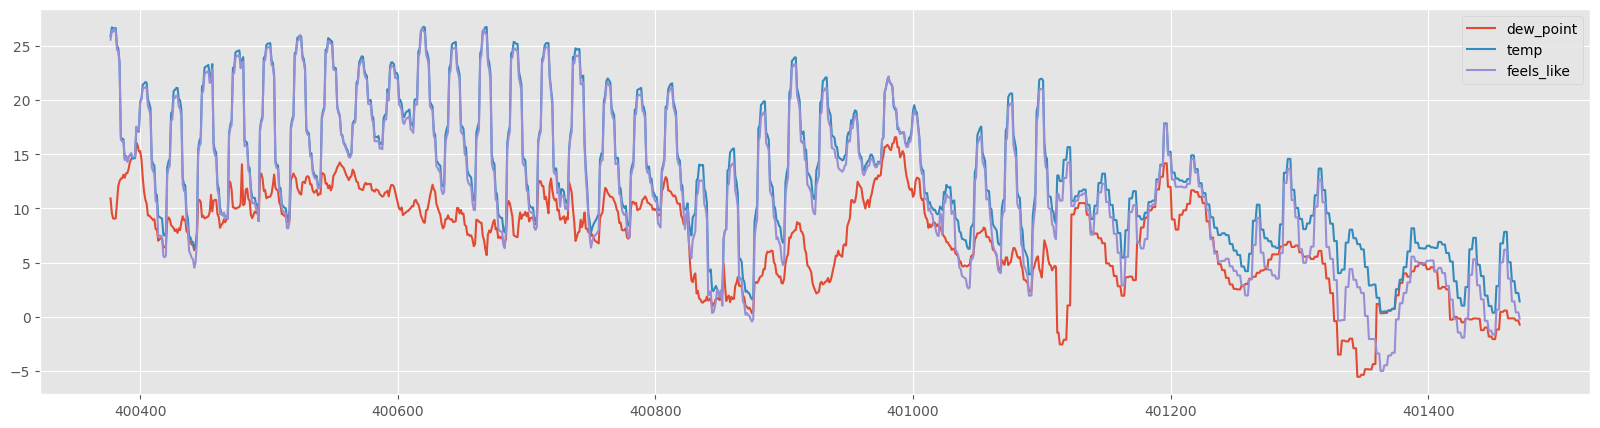

In [42]:
data[['dew_point', 'temp', 'feels_like']].plot()

Актуальная и ощутимая температура в целом почти совпадают, в то время как точка росы выглядит забавно - как будто подневную сезонность сгладили и оставили основной тренд температуры. Это забавное наблюдение, но оно к сожалению не дает никакой практической ценности с учетом того, что с температурой мы уже работаем. По сути остались только характеристики ветра - скорость и направление

<Axes: >

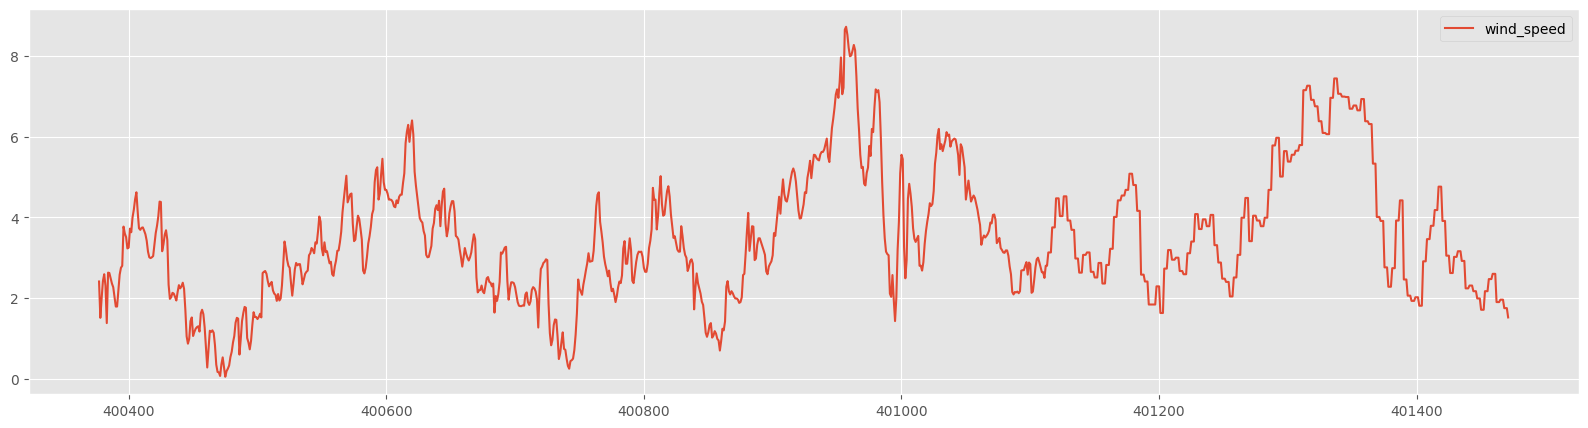

In [44]:
data[['wind_speed']].plot()

<Axes: >

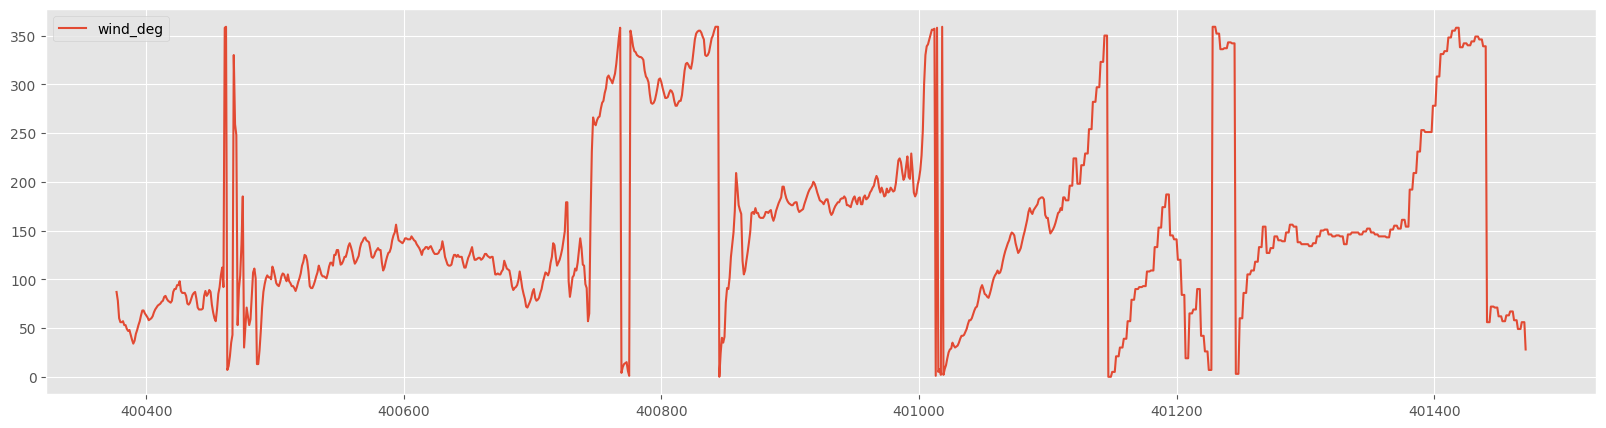

In [45]:
data[['wind_deg']].plot()

Направление ветра выглядит тоже неблагонадежно в общем-то, а вот скорость ветра выглядит интересно - ее и покрутим

# Разбиение на данные для тренировки и теста

In [68]:
from datetime import datetime

In [70]:
data['datetime'] = data['dt'].apply(datetime.fromtimestamp)
data = data.set_index('datetime')
data.index = data.index.to_period("h")

In [71]:
data.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,precipitations
datetime,,,,,,,,,,,,,,,,,,,,,
2024-09-03 09:00,1725354000,2024-09-03 09:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,25.93,NaN,10.93,25.60,...,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d,NaN
2024-09-03 10:00,1725357600,2024-09-03 10:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.73,NaN,9.58,26.41,...,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d,NaN
2024-09-03 11:00,1725361200,2024-09-03 11:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.67,NaN,9.08,26.33,...,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d,NaN
2024-09-03 12:00,1725364800,2024-09-03 12:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.64,NaN,9.06,26.64,...,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d,NaN
2024-09-03 13:00,1725368400,2024-09-03 13:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.68,NaN,9.09,26.34,...,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d,NaN


In [72]:
test_size = 8
train, test = data[:-test_size], data[-test_size:]
len(train)

1087

In [74]:
from sktime.forecasting.base import ForecastingHorizon

# ARIMA

In [118]:
import pmdarima
from pmdarima import model_selection
from sktime.utils.plotting import plot_correlations
from sktime.forecasting.arima import AutoARIMA, ARIMA
from pmdarima import auto_arima

In [83]:
param_to_predict = 'wind_speed'

In [87]:
y_stattest = data[param_to_predict]
criteria = sm.tsa.adfuller(y_stattest)

if criteria[0]> criteria[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

print()
criteria

единичных корней нет, ряд стационарен



(-3.9372410094238663,
 0.0017772418167474628,
 2,
 1092,
 {'1%': -3.436352507699052, '5%': -2.86419037625175, '10%': -2.56818114683546},
 674.1285220761761)

In [89]:
train = train[param_to_predict]

In [91]:
d = pmdarima.arima.ndiffs(train)
d

1

In [93]:
train = train.dropna()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='wind_speed'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

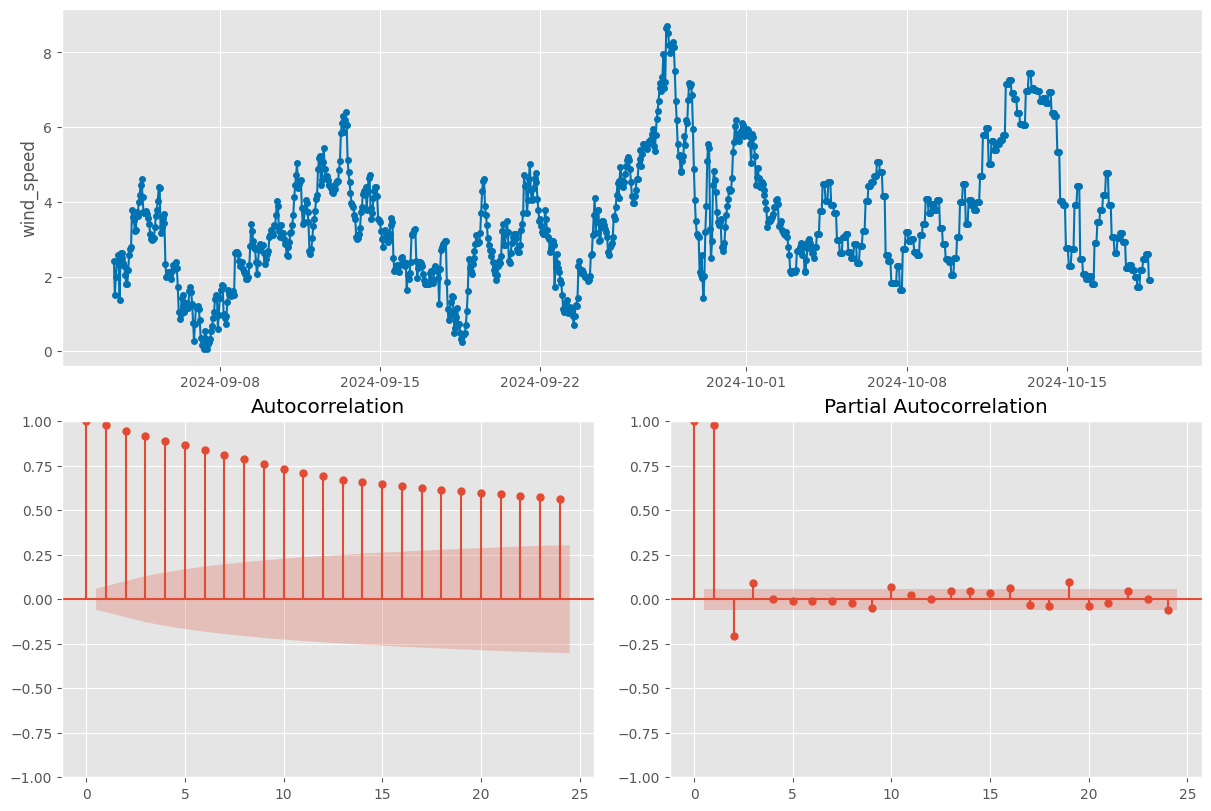

In [95]:
plot_correlations(train)

In [200]:
model = auto_arima(train,
                   start_p=0, start_q=0,
                   max_p=10, max_q=10,
                   d=2,
                   seasonal=False,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print("Best model:", model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1307.539, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1162.204, Time=0.29 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.77 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1305.543, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1050.743, Time=0.32 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=982.577, Time=0.43 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=942.871, Time=0.59 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=915.633, Time=0.75 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=888.328, Time=0.92 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=866.416, Time=1.18 sec
 ARIMA(8,2,0)(0,0,0)[0] intercept   : AIC=866.937, Time=1.47 sec
 ARIMA(7,2,1)(0,0,0)[0] intercept   : AIC=769.798, Time=9.02 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.91 sec
 ARIMA(8,2,1)(0,0,0)[0] intercept   : AIC=771.137, Time=9.60 sec
 ARIMA(7,2,2)(0,0,0)[0] intercept   : AIC=inf, Time

In [201]:
n_forecast = len(test)
y_pred = model.predict(n_periods=test_size)

print('MAE:', mean_absolute_percentage_error(test[param_to_predict], y_pred))
print('MSE:', mean_squared_error(test[param_to_predict], y_pred))
print('R2:', r2_score(test[param_to_predict], y_pred))

MAE: 0.04337660351899439
MSE: 0.009366512769909803
R2: 0.5589310446072934


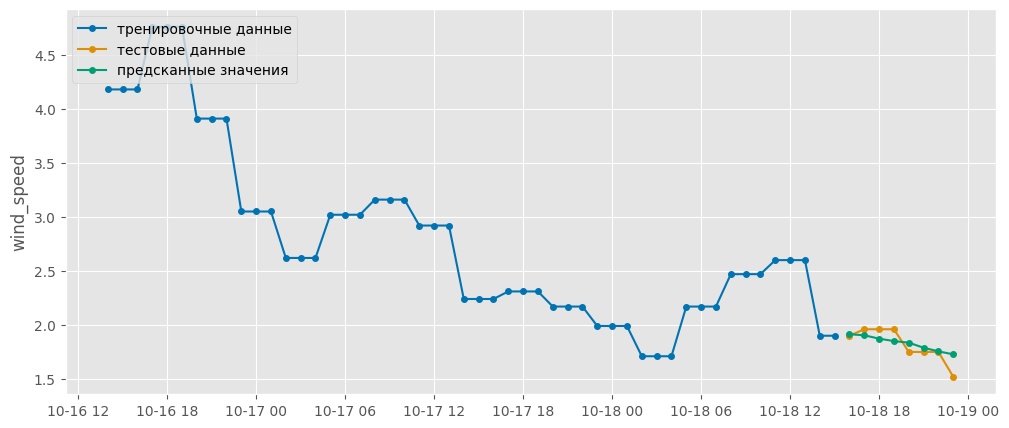

In [202]:
fig, ax = plot_series(train[-50:], test[param_to_predict], y_pred, labels=["тренировочные данные", "тестовые данные", "предсканные значения"])
ax.legend(loc='upper left')
ax.figure.set_size_inches(12, 5)

# ETS

In [155]:
from sktime.forecasting.ets import AutoETS

In [159]:
fh = ForecastingHorizon(list(range(1, test_size+1)))

In [162]:
model = AutoETS()
model.fit(train)

y_pred = model.predict(fh=fh)
print('MAE:', mean_absolute_percentage_error(test[param_to_predict], y_pred))
print('MSE:', mean_squared_error(test[param_to_predict], y_pred))
print('R2:', r2_score(test[param_to_predict], y_pred))

MAE: 0.07487245017649034
MSE: 0.027837501137500054
R2: -0.31086753940107714


In [163]:
print("Best model:", model.summary())

Best model:                                  ETS Results                                  
Dep. Variable:             wind_speed   No. Observations:                 1087
Model:                       ETS(ANN)   Log Likelihood                -385.021
Date:                Wed, 11 Dec 2024   AIC                            776.043
Time:                        19:53:24   BIC                            791.016
Sample:                    09-03-2024   HQIC                           781.711
                         - 10-18-2024   Scale                            0.119
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.033     29.958      0.000       0.934       1.065
initial_level       2.4110      0.346      6.966      0.000       1.733       3.089
Ljung-Box (Q):      

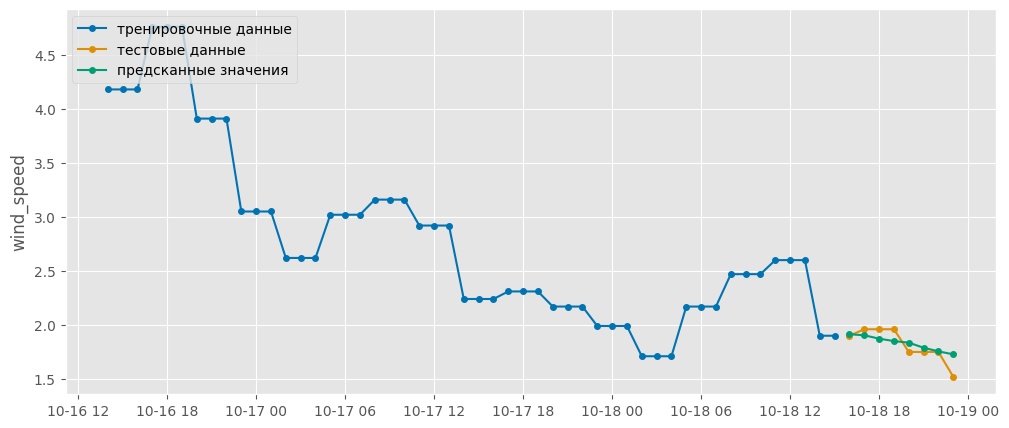

In [190]:
fig, ax = plot_series(train[-50:], test[param_to_predict], y_pred, labels=["тренировочные данные", "тестовые данные", "предсканные значения"])
ax.legend(loc='upper left')
ax.figure.set_size_inches(12, 5)

# Наивный прогноз

In [164]:
from sktime.forecasting.naive import NaiveForecaster

In [165]:
model = NaiveForecaster()
model.fit(train)

y_pred = model.predict(fh=fh)
print('MAE:', mean_absolute_percentage_error(test[param_to_predict], y_pred))
print('MSE:', mean_squared_error(test[param_to_predict], y_pred))
print('R2:', r2_score(test[param_to_predict], y_pred))

MAE: 0.07487244897959182
MSE: 0.027837499999999984
R2: -0.3108674858362148


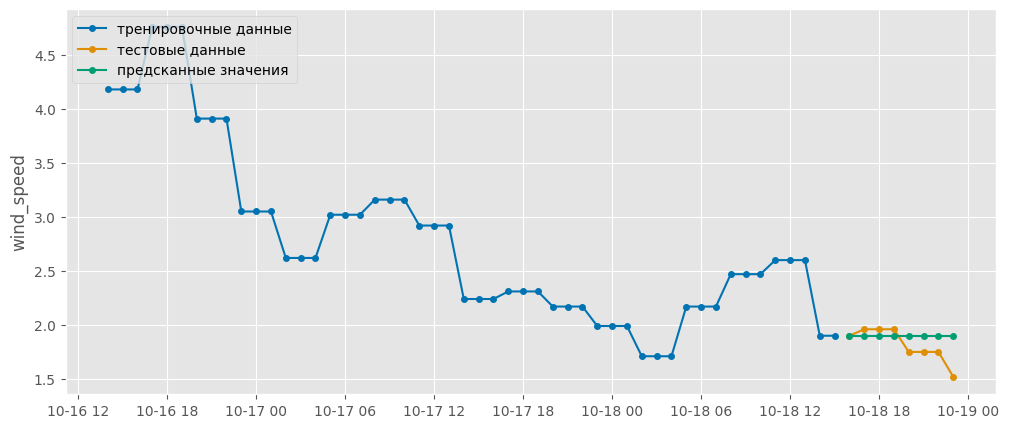

In [166]:
fig, ax = plot_series(train[-50:], test[param_to_predict], y_pred, labels=["тренировочные данные", "тестовые данные", "предсканные значения"])
ax.legend(loc='upper left')
ax.figure.set_size_inches(12, 5)

итого лучше всего себя показала ARIMA с параметрами (7,2,1)